In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from tensorflow.keras import Model
import sys
sys.path.append("..")   # add parent directory to Python path
import functions
from pathlib import Path


In [2]:
data_lst = []
scaler = MinMaxScaler(feature_range=(0,1))
folder = Path("D:\Documents\GitHub\ML_cardiac_prediction\data")
for p in folder.glob("*.csv"):   # use rglob("*.csv") for subfolders
    voltage = functions.load_voltage('../data/tau_d_0.408_temporal_APD_step_4 (1).csv')
    scaled_voltage = scaler.fit_transform(voltage.reshape(-1, 1))
    data_lst.append(scaled_voltage)

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\11061\AppData\Local\Temp\ipykernel_29092\1957744654.py:3: SyntaxWarning: invalid escape sequence '\D'
  folder = Path("D:\Documents\GitHub\ML_cardiac_prediction\data")


In [3]:
window_size = 4500
prediction_size = 500
X = []
y = []

for scaled_voltage in data_lst:
    X.append(scaled_voltage[0:window_size, 0])
    y.append(scaled_voltage[window_size:window_size+prediction_size, 0])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [4]:
# ========== 2) AUTOENCODER (single Sequential) ==========
# Choose a pair from your table: [H, L] = [128, 32] for example.
H, L = 128, 32

sequence_length = 4500  # Your original sequence length

model = Sequential()

# Encoder part
model.add(LSTM(H, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(L, return_sequences=True))

# Decoder part  
model.add(LSTM(H, return_sequences=True))
model.add(TimeDistributed(Dense(1)))  # Output (batch, time, 1), TimeDistributed helps to handle all dim after second ones

print("LSTM Autoencoder Summary:")
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mse')

LSTM Autoencoder Summary:


D:\Anaconda\envs\lstm\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4500, 128)           │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 4500, 32)            │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 4500, 128)           │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 4500, 1)             │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,729 (663.00 KB)

 Trainable params: 169,729 (663.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, X_train,
                         validation_data=(X_test, X_test),
                         epochs=60, 
                         batch_size=32,
                         verbose=1 )

Epoch 1/60


In [60]:
# Build an encoder view to extract z (still starting from the same Sequential model)
encoder = Model(inputs=model.layers[0].input,
                outputs=model.layers[2].output)  # layer[2] = Dense(L)
# Decoder (create independent input)
latent_input = tf.keras.Input(shape=(L,))
x = model.layers[3](latent_input)        
x = model.layers[4](x)                   
decoder_output = model.layers[5](x)
decoder = Model(inputs=latent_input, outputs=decoder_output)

In [79]:
latent_test

array([[ 0.5630894 , -2.7690008 ,  2.2156308 ,  0.34576356,  1.1489224 ,
        -3.8704467 , -1.6942462 ,  1.0227678 ,  0.7768383 , -0.37988394,
        -0.8623227 ,  3.6491816 ,  1.5539939 , -1.5777305 , -1.6312454 ,
         4.3034496 ,  0.726013  , -1.5313622 ,  0.19859746,  1.801282  ,
        -0.8027446 , -0.5249968 , -1.0303067 ,  3.3219194 , -2.3915427 ,
        -2.2514    , -4.26104   ,  3.1001806 ,  0.07311882, -0.7945057 ,
        -2.4703708 , -2.4415612 ],
       [ 0.5630894 , -2.7690008 ,  2.2156308 ,  0.34576356,  1.1489224 ,
        -3.8704467 , -1.6942462 ,  1.0227678 ,  0.7768383 , -0.37988394,
        -0.8623227 ,  3.6491816 ,  1.5539939 , -1.5777305 , -1.6312454 ,
         4.3034496 ,  0.726013  , -1.5313622 ,  0.19859746,  1.801282  ,
        -0.8027446 , -0.5249968 , -1.0303067 ,  3.3219194 , -2.3915427 ,
        -2.2514    , -4.26104   ,  3.1001806 ,  0.07311882, -0.7945057 ,
        -2.4703708 , -2.4415612 ],
       [ 0.5630894 , -2.7690008 ,  2.2156308 ,  0.3457

In [78]:
x_pred.shape

(16, 4500, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
RMSE: 0.012597


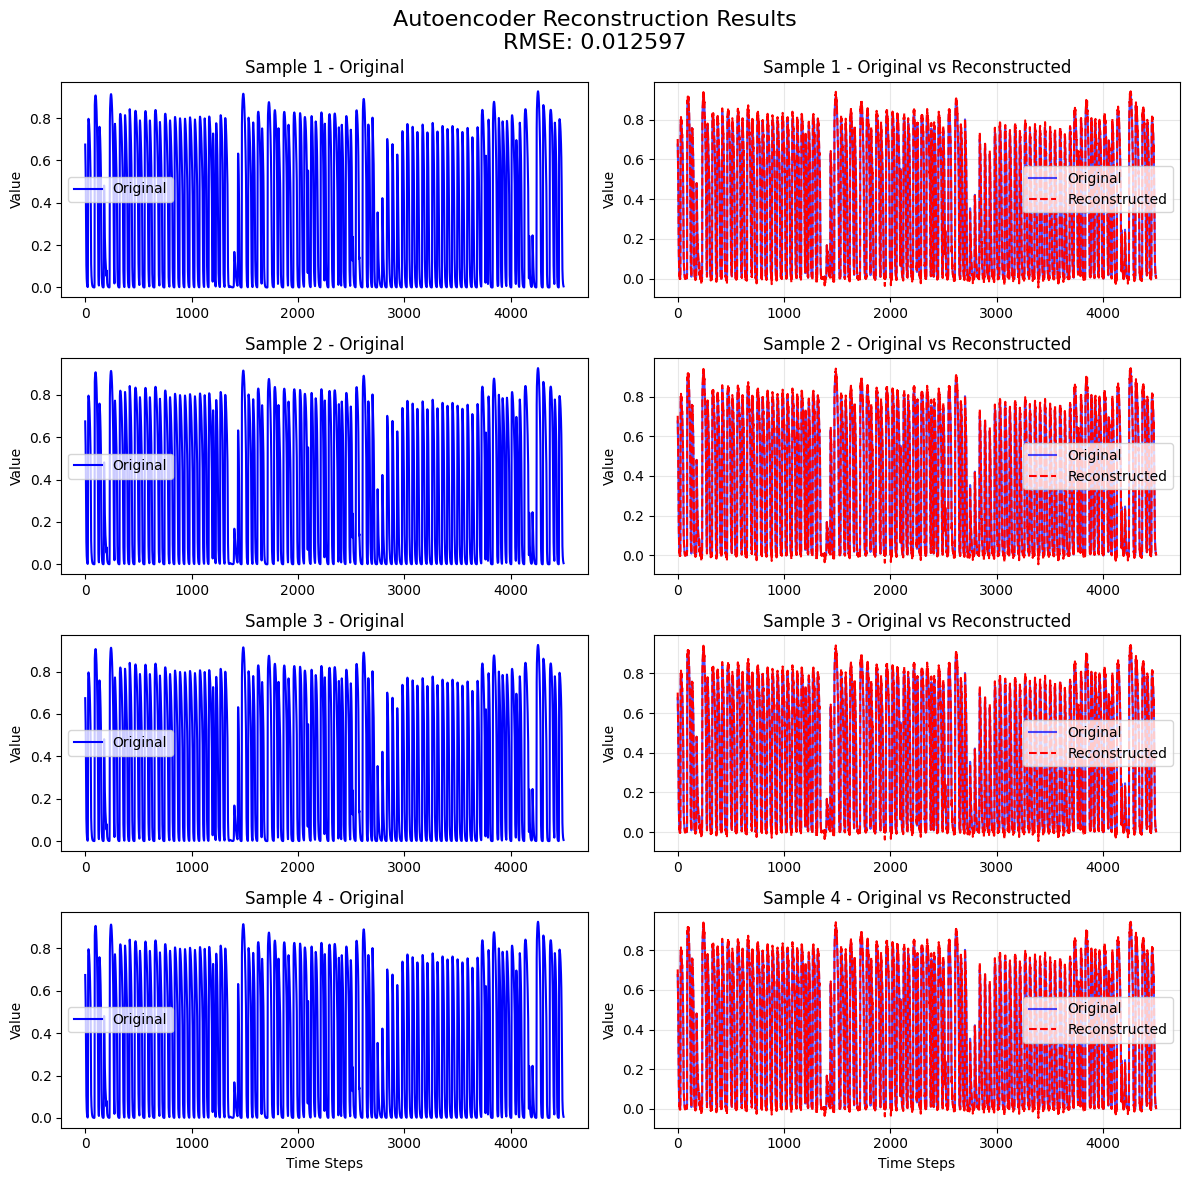

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Get predictions
latent_test = encoder.predict(X_train)
x_pred = decoder.predict(latent_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(X_train.flatten(), x_pred.flatten()))
print(f"RMSE: {rmse:.6f}")

# Plot comparison for first few samples
n_samples = 4 # Number of samples to plot
fig, axes = plt.subplots(n_samples, 2, figsize=(12, 3*n_samples))
fig.suptitle(f'Autoencoder Reconstruction Results\nRMSE: {rmse:.6f}', fontsize=16)

for i in range(n_samples):
    # Original data
    axes[i, 0].plot(X_train[i].flatten(), 'b-', linewidth=1.5, label='Original')
    axes[i, 0].set_title(f'Sample {i+1} - Original')
    axes[i, 0].set_ylabel('Value')
    axes[i, 0].legend()
    
    # Reconstructed data
    axes[i, 1].plot(X_train[i].flatten(), 'b-', linewidth=1.5, label='Original', alpha=0.7)
    axes[i, 1].plot(x_pred[i].flatten(), 'r--', linewidth=1.5, label='Reconstructed')
    axes[i, 1].set_title(f'Sample {i+1} - Original vs Reconstructed')
    axes[i, 1].set_ylabel('Value')
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].legend()
    
    if i == n_samples-1:  # Add x-label only to bottom plots
        axes[i, 0].set_xlabel('Time Steps')
        axes[i, 1].set_xlabel('Time Steps')

plt.tight_layout()
plt.show()